In [ ]:
%load_ext autoreload
%autoreload 2

# Import Required Libraries
Import the necessary pdf2image and OpenAI.

In [ ]:
# Importing required libraries
from fastcore.all import AttrDict
import io
from pdf2image import convert_from_path
import PyPDF2
import openai
import os
import base64
import requests

# Load and Convert PDF to Image
Use PyPDF2 pdf2image to load the PDF file and convert it into an image.

In [ ]:
# Load the PDF file
path = f'../example_data/1.pdf'

# Open the PDF file
with open(path, 'rb') as file:
    pdf = PyPDF2.PdfFileReader(file)

    # Check if the PDF has more than one page
    if pdf.getNumPages() > 1:
        print("The PDF has more than one page. Only the first page will be converted to an image.")

# Convert the PDF to images
images = convert_from_path(path, last_page=1, first_page=0, fmt='jpeg')

The PDF has more than one page. Only the first page will be converted to an image.


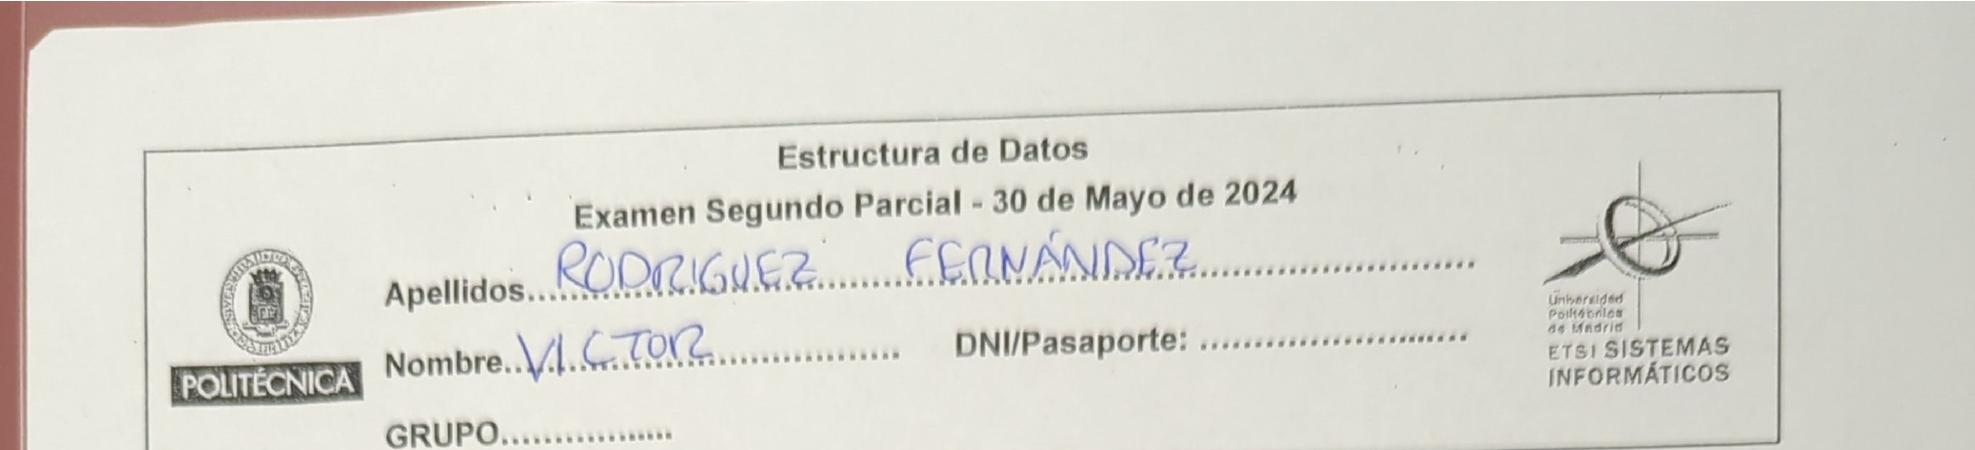

In [ ]:
# Crop the image
image = images[0].crop((0, 0, images[0].width, 450))
image

# Call OpenAI ChatGPT API with Vision Model
Use the OpenAI API to call the ChatGPT model with the vision capability.

In [ ]:
buffered = io.BytesIO()
images[0].save(buffered, format="JPEG")
base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
base64_image

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAraB7cDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCT+39Z/wCgtff+BL/40f2/rGP+Qtf/APgS/wDjWbSjgVyXZ63JHsb2ma1q0l2ofVL1lx0Nw5/rTpdb1YXMqjU70AMcD7Q/+NUNJz9sX6USktcTH/bNO7JcI32Lv9t6t/0FL3/wIf8Axpf7a1b/AKCl7/4EP/jWfSg0XDkj2L4

In [ ]:
api_key = os.environ["OPENAI_API_KEY"] # *
prompt = """Extract the last name (Apellidos in Spanish) and the first name (Nombre in Spanish)
 from the top of the image. You will find them handwritten after the labels `Apellidos` 
 and `Nombre` respectively. The fields of your JSON output will have those exact same label names""" # *
model = "gpt-4o"

In [ ]:
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

payload = {
  "model": f'{model}',
  "response_format": { "type": "json_object" },
  "messages": [
    {
        "role": "system", 
        "content": "You are a helpful assistant designed to see an exam and output JSON \
           with the extracted information. You will be given an image of the exam.",   
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": f"{prompt}"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

In [ ]:
info = response.json()['choices'][0]['message']['content']
info

'{\n  "Apellidos": "RODRIGUEZ FERNANDEZ",\n  "Nombre": "VICTOR"\n}'

In [ ]:
# Add path to the info dictionary
info['path'] = path